In [1]:

import nibabel as nib
import nilearn as nil

from nilearn import input_data
from nilearn import datasets
from nilearn import image

from nilearn import plotting
from nilearn.plotting import plot_prob_atlas, plot_roi, plot_matrix
from nilearn.image import index_img
from nilearn.regions import RegionExtractor
from nilearn.connectome import ConnectivityMeasure
from nilearn.glm.first_level import FirstLevelModel
from nilearn.image import concat_imgs, index_img, mean_img, new_img_like
from nilearn import datasets
from nilearn.image import concat_imgs, index_img, mean_img, new_img_like
from nilearn.input_data import NiftiMasker
from nilearn.decoding import SearchLight, DecoderRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

import seaborn as sns

from glob import glob
from tqdm import tqdm

import numpy as np
import scipy as sp
import pandas as pd
import re
import csv

from sklearn.preprocessing import Normalizer
from sklearn import svm

import os, sys
from os.path import dirname, exists

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

/opt/anaconda3/envs/neu502b/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
all_nifti_files = glob(os.path.join('data','derivatives','fsl',
                          'sub-*',
                          'func','sub-*_task-beads_run-*_desc-preproc_bold.nii.gz'))

subject_ids = [re.search(r'-.*', strr)[0][1:] for strr in glob(os.path.join('data','derivatives','fsl','sub-*'))]

# os.path.join('data',f'sub-{subject}',
#                              'func',
#                             f'sub-{subject}_task-beads_run-{run}_events.tsv')


In [3]:
nifti_data_paths = {subject:{run:[] for run in [1,2,3,4]} for subject in subject_ids}

for subject in subject_ids:
    for run in [1,2,3,4]:
        path = os.path.join('data','derivatives','fsl',
                          'sub-{}'.format(subject),
                          'func',f'sub-{subject}_task-beads_run-{run}_desc-preproc_bold.nii.gz')
        nifti_data_paths[subject][run] = path
        
        
        

In [4]:
all_behav_data = pd.DataFrame(columns=['onset', 'duration', 'event_type', 'num_beads_high', 'num_beads_low',
       'points_high', 'bead_type', 'bet_jar_type', 'button', 'initialVOI',
       'updatedVOI','subject','run'])

for subject in subject_ids:
    for run in [1,2,3,4]:
        path = os.path.join('data',f'sub-{subject}',
                             'func',
                            f'sub-{subject}_task-beads_run-{run}_events.tsv')
        
        tmp_behav_df = pd.read_csv(path, sep='\t')
        tmp_behav_df['subject'] = subject
        tmp_behav_df['run'] = run

        all_behav_data=pd.concat([all_behav_data, tmp_behav_df] )

# to mark clean data avaibiltity
all_behav_data['clean_data'] = False        

In [5]:
all_behav_data = all_behav_data.reset_index(drop=True)

In [6]:
## prep df

all_behav_data['additional_draw_T'] = 0 # time for additional draws
all_behav_data['additional_draw_N_high'] = 0 # nunber of additional high draws
all_behav_data['additional_draw_N_low'] = 0 # nunber of additional low draws


tmp_all_behav_data = all_behav_data[all_behav_data.event_type.isin([#'initial_beads',
                                                #'extra_bead',
                                        'additional_draw_allowed',
                                               'terminate_draw',
                                              ])][['onset',
                                                  'event_type',
                                                 'num_beads_high',
                                                 'num_beads_low']]

In [7]:
### add additioanl draw info to df
for (i0, row0), (i1, row1) in zip(tmp_all_behav_data[:-1].iterrows(),
                    tmp_all_behav_data[1:].iterrows()):

    
    if (row0.event_type=='additional_draw_allowed') &\
             (row1.event_type=='terminate_draw'):
        delta_t = row1.onset - row0.onset
        additional_draw_N_high = row1.num_beads_high - row0.num_beads_high
        additional_draw_N_low = row1.num_beads_low - row0.num_beads_low

        all_behav_data.loc[i0,['additional_draw_T']] = delta_t
        all_behav_data.loc[i0,['additional_draw_N_high']] = additional_draw_N_high
        all_behav_data.loc[i0,['additional_draw_N_low']] = additional_draw_N_low

  

In [8]:
TR = 1.5

In [9]:
func_trials_all = []
y_T = []
y_nl = []
y_nh = []
y_curr_nl = []
y_curr_nh = []

y_reward_type = []
for sub_i, sub in tqdm(enumerate(nifti_data_paths)):
    for run in nifti_data_paths[sub]:
        
        img = nifti_data_paths[sub][run]
        
        sub_df = all_behav_data[(all_behav_data['subject']==sub) &\
               (all_behav_data['run']==run) &\
            (all_behav_data['event_type']=='additional_draw_allowed')]        
        
        #indexes
        x = np.array(sub_df.onset/TR+3, dtype=int)
        indexes = x[x<400]
        n = len(indexes)                     
        # add   
        try:
            func_trials_all.append(index_img(img, indexes))
            
            y_T.append(sub_df.additional_draw_T.to_list()[:n])
            y_nl.append(sub_df.additional_draw_N_low.to_list()[:n]) 
            y_nh.append(sub_df.additional_draw_N_high.to_list()[:n])
            y_curr_nl.append(sub_df.num_beads_high.to_list()[:n])
            y_curr_nh.append(sub_df.num_beads_low.to_list()[:n])
            y_reward_type.append(sub_df.points_high.to_list()[:n])
        
        except EOFError:
            continue


15it [03:29, 13.95s/it]


In [10]:
y_T_flat = np.array([item for sublist in y_T for item in sublist])
y_nl_flat = np.array([item for sublist in y_nl for item in sublist])
y_nh_flat = np.array([item for sublist in y_nh for item in sublist])
y_curr_nl_flat = np.array([item for sublist in y_curr_nl for item in sublist])
y_curr_nh_flat = np.array([item for sublist in y_curr_nh for item in sublist])

y_curr_nl_arr = np.array(y_curr_nl)
y_curr_nh_arr = np.array(y_curr_nh)


y_reward_type_flat = np.array([item for sublist in y_reward_type for item in sublist])


In [11]:
# time to draw/n of draws
y_T_norm = y_T_flat/(y_nl_flat+y_nh_flat+1)

# diff in categories / total beads
y_H = np.abs(y_curr_nl_flat-y_curr_nh_flat)/(y_curr_nl_flat+y_curr_nh_flat)



In [12]:
## entropy
get_H = lambda p: -1*np.sum([p_i*np.log2(p_i) for p_i in p], axis=0)

In [13]:
p_l= y_curr_nl_flat/ (y_curr_nl_flat + y_curr_nh_flat)
p_h= y_curr_nh_flat/ (y_curr_nl_flat + y_curr_nh_flat)

In [14]:

y_ent = get_H([p_h, p_l])

In [15]:
func_trials = []
for img in func_trials_all:
    for ind in range(img.shape[3]):
         func_trials.append(index_img(img, ind))
    

In [17]:
func_mean = mean_img(func_trials)

masker = NiftiMasker(mask_strategy='epi').fit(func_mean)
mask = masker.mask_img_

In [18]:
func_trials_all_resample = []
for img in func_trials_all:
    img0 = image.resample_img(img, 
                   target_affine=mask.get_affine(), 
                   target_shape=mask.shape)
    func_trials_all_resample.append(img0)

In [20]:
func_trials_resample = []
for img in func_trials:
    img0 = image.resample_img(img, 
                   target_affine=mask.get_affine(), 
                   target_shape=mask.shape)
    func_trials_resample.append(img0)

In [ ]:
## regress

In [54]:
searchlight = SearchLight(mask_img=mask, 
                          radius=5.6, 
                          estimator='svr',
                          n_jobs=1,
                          cv=None,
                          verbose=1)


In [101]:
train_ids = np.random.choice(len(func_trials_resample), 10)


In [100]:
searchlight.fit(func_trials_resample[100:110], y_T_norm[100:110])

In [53]:
results = new_img_like(func_mean, searchlight.scores_)

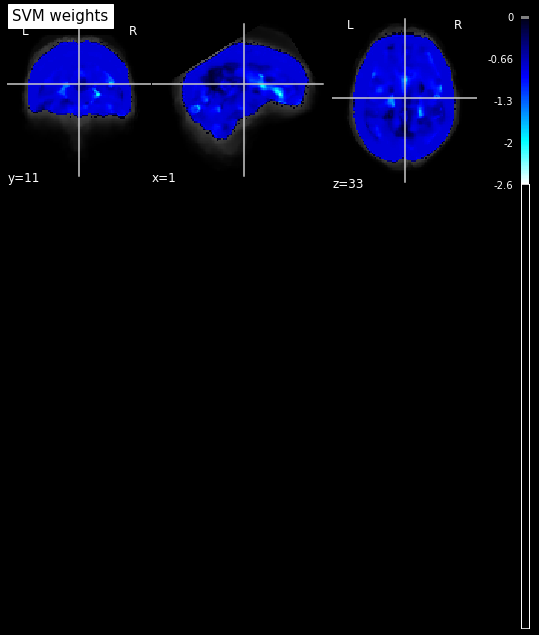

In [122]:
from nilearn.plotting import plot_stat_map, show
bg_filename = func_mean
display = plot_stat_map(results, 
                        bg_img=bg_filename, 
                        threshold=.03)
display.title("SVM weights")
plt.show()